In [214]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.util import log_likelihood
npy.enable_x64()

import arviz as az

import jax.random as jr
import jax.numpy as np
import dLux as dl
import matplotlib.pyplot as plt

from dLuxWebbpsf import NIRCam

# Set global plotting parameters
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'serif'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120


def toRad(arcsecs):
    return arcsecs * np.pi / (180*3600)

In [170]:
wavels = np.array([2.82792251e-06])
weights = np.array([1])

spec = dl.Spectrum(wavels, weights)

true_x = 0.1
true_y = 0.3

source_offset_x = toRad(true_x)
source_offset_y = toRad(true_y)

offset = np.array([source_offset_x, source_offset_y])

flux = np.exp(8)

source = dl.PointSource(wavelengths=wavels, spectrum=spec, position=offset, flux=flux)

In [171]:
webb_options = {
    'jitter': None,   # jitter model name or None
    'jitter_sigma': 0.000,  # in arcsec per axis, default 0.007
    'add_distortion': False,
}

optics = NIRCam(filter = "F300M",
                pupil_mask = None,
                coron_mask = None,
                detector = "NRCA5",
                aperture = "NRCA5_FULL_MASK430R",
                fft_oversample=1,
                fov_arcsec=None,
                #fov_pixels=56,
                fov_pixels=16,
                wavefront_downsample=8,
                options=webb_options)

# Construct Telescope
telescope = dl.Instrument(optics, (source,'source'))

INFO:webbpsf:NIRCam aperture name updated to NRCA1_FULL
INFO:webbpsf:NIRCam pixel scale switched to 0.063000 arcsec/pixel for the long wave channel.
INFO:webbpsf:NIRCam aperture name updated to NRCA5_FULL
INFO:webbpsf:NIRCam aperture name updated to NRCA5_FULL_MASK430R
INFO:webbpsf:Creating optical system model:
INFO:poppy:Initialized OpticalSystem: JWST+NIRCam
INFO:poppy:JWST Entrance Pupil: Loaded amplitude transmission from /Users/uqitroit/Dev/optics/webbpsf-data/jwst_pupil_RevW_npix1024.fits.gz
INFO:poppy:JWST Entrance Pupil: Loaded OPD from /Users/uqitroit/Dev/optics/webbpsf-data/JWST_OTE_OPD_cycle1_example_2022-07-30.fits
INFO:webbpsf:Loading field dependent model parameters from /Users/uqitroit/Dev/optics/webbpsf-data/NIRCam/OPD/field_dep_table_nircam.fits
INFO:webbpsf:Calculating field-dependent OTE OPD at v2 = 1.456 arcmin, v3 = -6.752 arcmin
INFO:poppy:Added pupil plane: JWST Entrance Pupil
INFO:poppy:Added coordinate inversion plane: OTE exit pupil
INFO:poppy:Added pupil pla

pixel scale: 3.054326190990077e-07


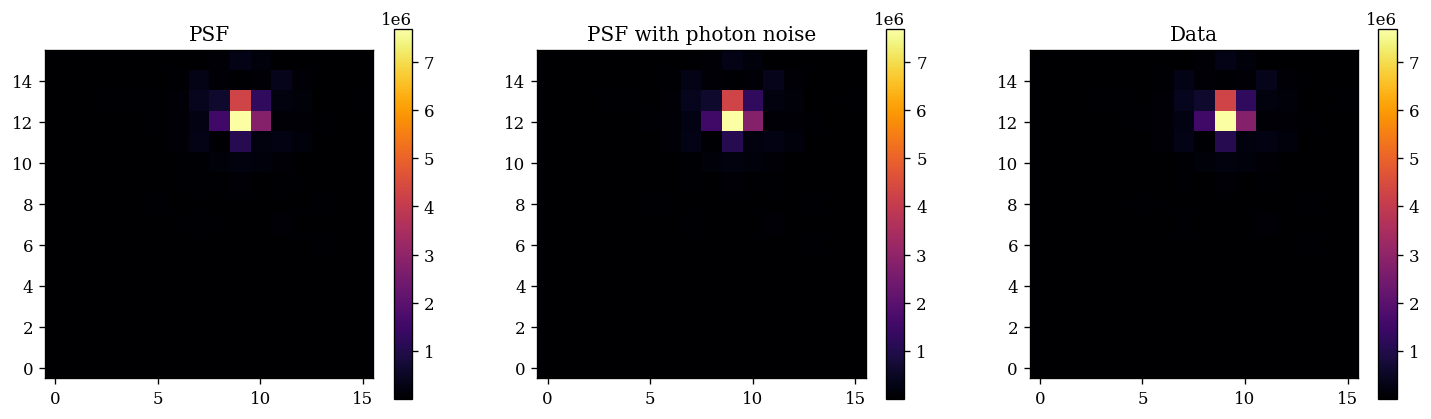

In [172]:
 ## Generate psf
psf = telescope.model()
psf_photon = jr.poisson(jr.PRNGKey(0), psf)
bg_noise = 3*jr.normal(jr.PRNGKey(0), psf_photon.shape)
data = psf_photon + bg_noise

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("PSF")
plt.imshow(psf)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("PSF with photon noise")
plt.imshow(psf_photon)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Data")
plt.imshow(data)
plt.colorbar()
plt.show()

In [173]:
pixscale = 0.06 #arcsec
n_rad = 0.04

In [174]:
0.06 * 0.04

0.0024

In [175]:
pixscale*n_rad

0.0024

In [176]:
true_x + pixscale*n_rad

0.1024

In [177]:
true_x 

0.1

In [178]:
true_x - pixscale*n_rad

0.0976

In [204]:
# PPL
import numpyro as npy
import numpyro.distributions as dist

#parameters = ['position', 'flux']
parameters = ['position']

def psf_model(data, data_err, model):
    """
    Define the numpyro function
    """
    
    
    #x_sample = npy.sample("x",        dist.Uniform(true_x - pixscale*n_rad, true_x + pixscale*n_rad))
    #y_sample = npy.sample("y",        dist.Uniform(true_y - pixscale*n_rad, true_y + pixscale*n_rad))
    
    x_sample = npy.sample("x",        dist.Uniform(0.09, 0.11))
    y_sample = npy.sample("y",        dist.Uniform(0.29, 0.31))
    
    #x_sample = npy.sample("x",        dist.Uniform(0.099, 0.101))
    #y_sample = npy.sample("y",        dist.Uniform(0.299, 0.301))
    #flux_sample = npy.sample("log_flux", dist.Uniform(7, 9))
    
    #det_flux = np.exp(flux_sample)
    det_x = toRad(x_sample)
    det_y = toRad(y_sample)
    
    values = [
        [det_x, det_y],
        #det_flux
    ]

    with npy.plate("data", len(data.flatten())):
        dist_model = dist.Normal(model.set(parameters, values).model().flatten(), data_err)
        npy.sample("psf", dist_model, obs=data.flatten())

In [205]:
data_err = 3 * np.ones_like(data.flatten())

In [334]:
from jax import device_count
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),    
    num_warmup=2000,
    num_samples=2000,
    num_chains=device_count(),
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(3), data, data_err, telescope)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 58.4 s, sys: 3.04 s, total: 1min 1s
Wall time: 24 s


In [335]:
sampler.print_summary()
values_out = sampler.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.10      0.00      0.10      0.10      0.11      2.00   1626.13
         y      0.30      0.00      0.30      0.30      0.30      2.00    702.76

Number of divergences: 9


In [336]:
print(values_out)

{'x': Array([0.10000301, 0.10000301, 0.10000299, ..., 0.10000299, 0.10000297,
       0.10000297], dtype=float64), 'y': Array([0.30000373, 0.30000373, 0.3000037 , ..., 0.3000037 , 0.30000371,
       0.30000372], dtype=float64)}


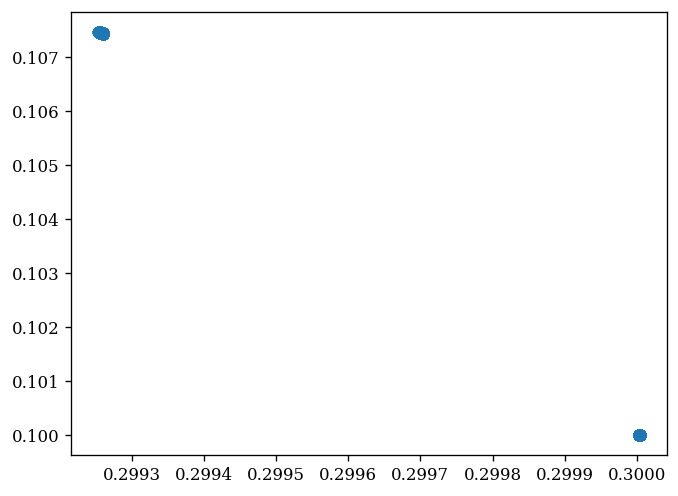

In [337]:
plt.scatter(values_out['y'], values_out['x'])

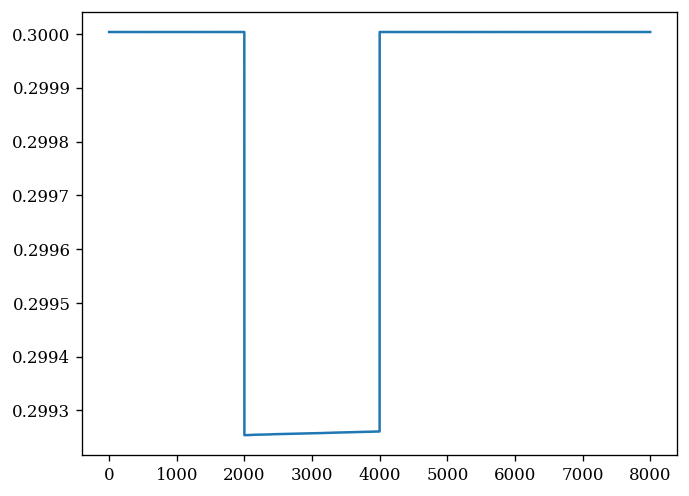

In [338]:
plt.plot(values_out['y'])

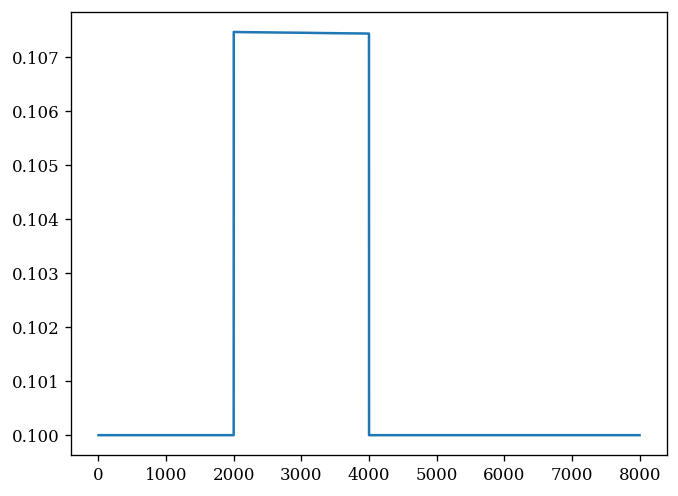

In [339]:
plt.plot(values_out['x'])

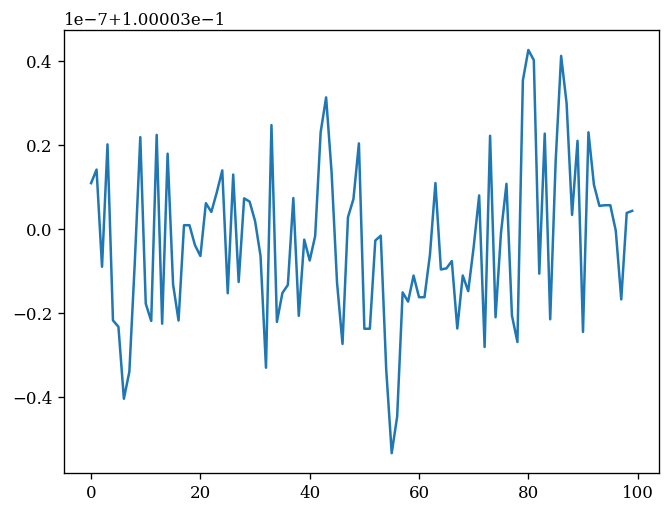

In [340]:
plt.plot(values_out['x'][:100])

In [341]:
nsteps = 10
vals = zip(values_out['x'][:nsteps], values_out['y'][:nsteps])

for (x,y) in vals:
    print((str(x), str(y)))

('0.10000301095451915', '0.3000037259774868')
('0.10000301418321436', '0.3000037293156373')
('0.1000029910315609', '0.3000036962835412')
('0.10000302019338361', '0.3000037196128636')
('0.10000297824305343', '0.30000370808188')
('0.10000297673179233', '0.3000036876819504')
('0.10000295957045761', '0.3000037147447092')
('0.10000296601649407', '0.3000036968672724')
('0.10000299216080959', '0.3000037205294738')
('0.10000302191473112', '0.30000369742198063')


In [342]:
lls = log_likelihood(psf_model, values_out, data, data_err, telescope)['psf']

In [343]:
print(lls)

[[-4.78538385 -2.37948393 -6.56786839 ... -2.01772358 -2.6581582
  -2.44533586]
 [-4.78539016 -2.37943715 -6.56814118 ... -2.0177245  -2.65811955
  -2.44535812]
 [-4.78534811 -2.37989925 -6.56582343 ... -2.01771626 -2.65847391
  -2.44509344]
 ...
 [-4.78533739 -2.37984341 -6.56581043 ... -2.01771669 -2.65845245
  -2.44516038]
 [-4.78529686 -2.37975526 -6.56535213 ... -2.01771655 -2.65845049
  -2.44531836]
 [-4.78528892 -2.37951191 -6.56601473 ... -2.0177198  -2.65830453
  -2.44552441]]


In [344]:
def get_ll(x, y):
    values = {
        'x': np.array(x),
        'y': np.array(y),
    }
    return log_likelihood(psf_model, values, data, data_err, telescope)['psf'].sum()

#get_ll(values_out['x'][0], values_out['y'][0])

grad_ll = jax.grad(get_ll, argnums=[0,1])

grad_values = grad_ll(values_out['x'], values_out['y'])



In [345]:
grad_x, grad_y = grad_values

print(grad_x)

[-43475125.82659491 -53369332.4929253   17743505.48674913 ...
  29881008.77656293  80021348.07372038  82043156.47199515]


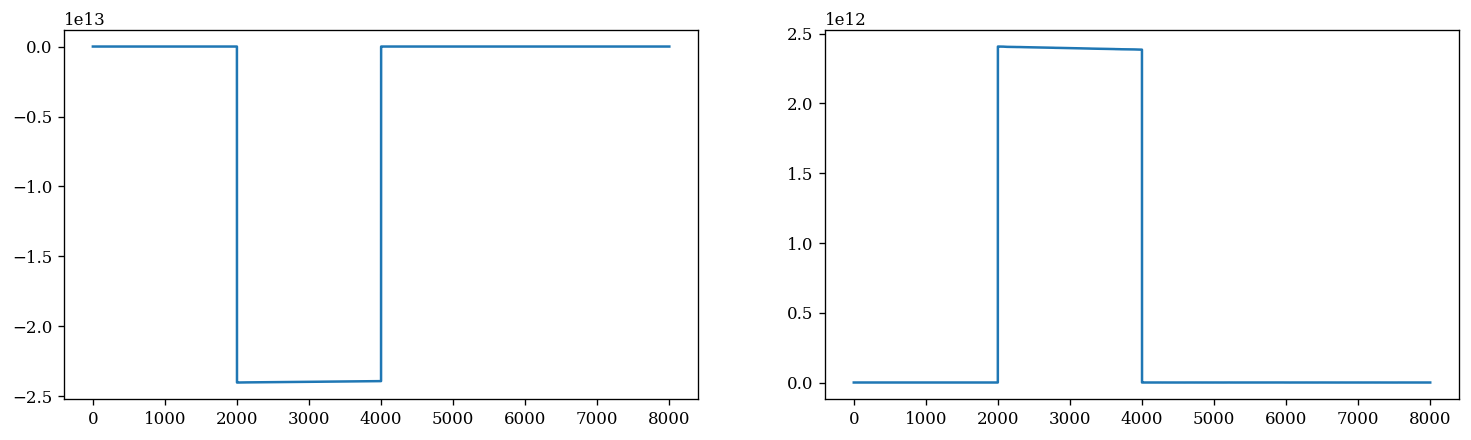

In [352]:

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(grad_x[:8000])

plt.subplot(1, 2, 2)
plt.plot(grad_y[:8000])

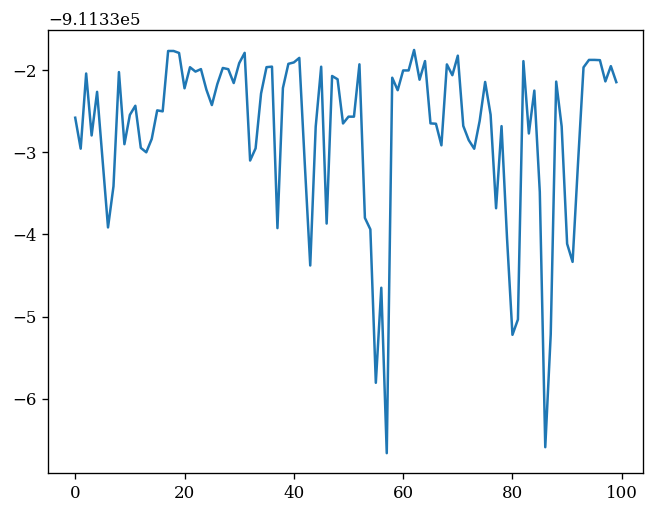

In [347]:
ll_sum = lls.sum(axis=1)
plt.plot(ll_sum[:100])

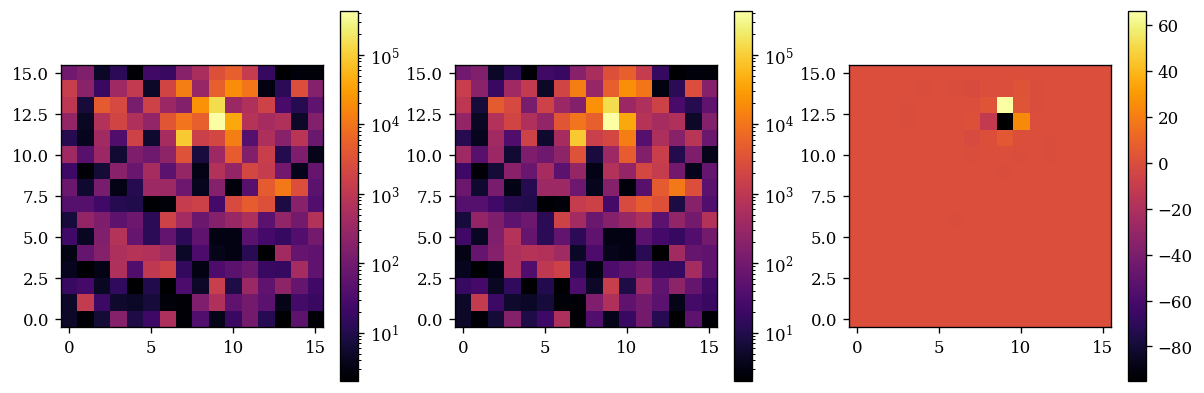

In [348]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(-lls[0].reshape((16,16)), norm='log')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(-lls[1].reshape((16,16)), norm='log')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow((lls[0] - lls[1]).reshape((16,16)))
plt.colorbar()

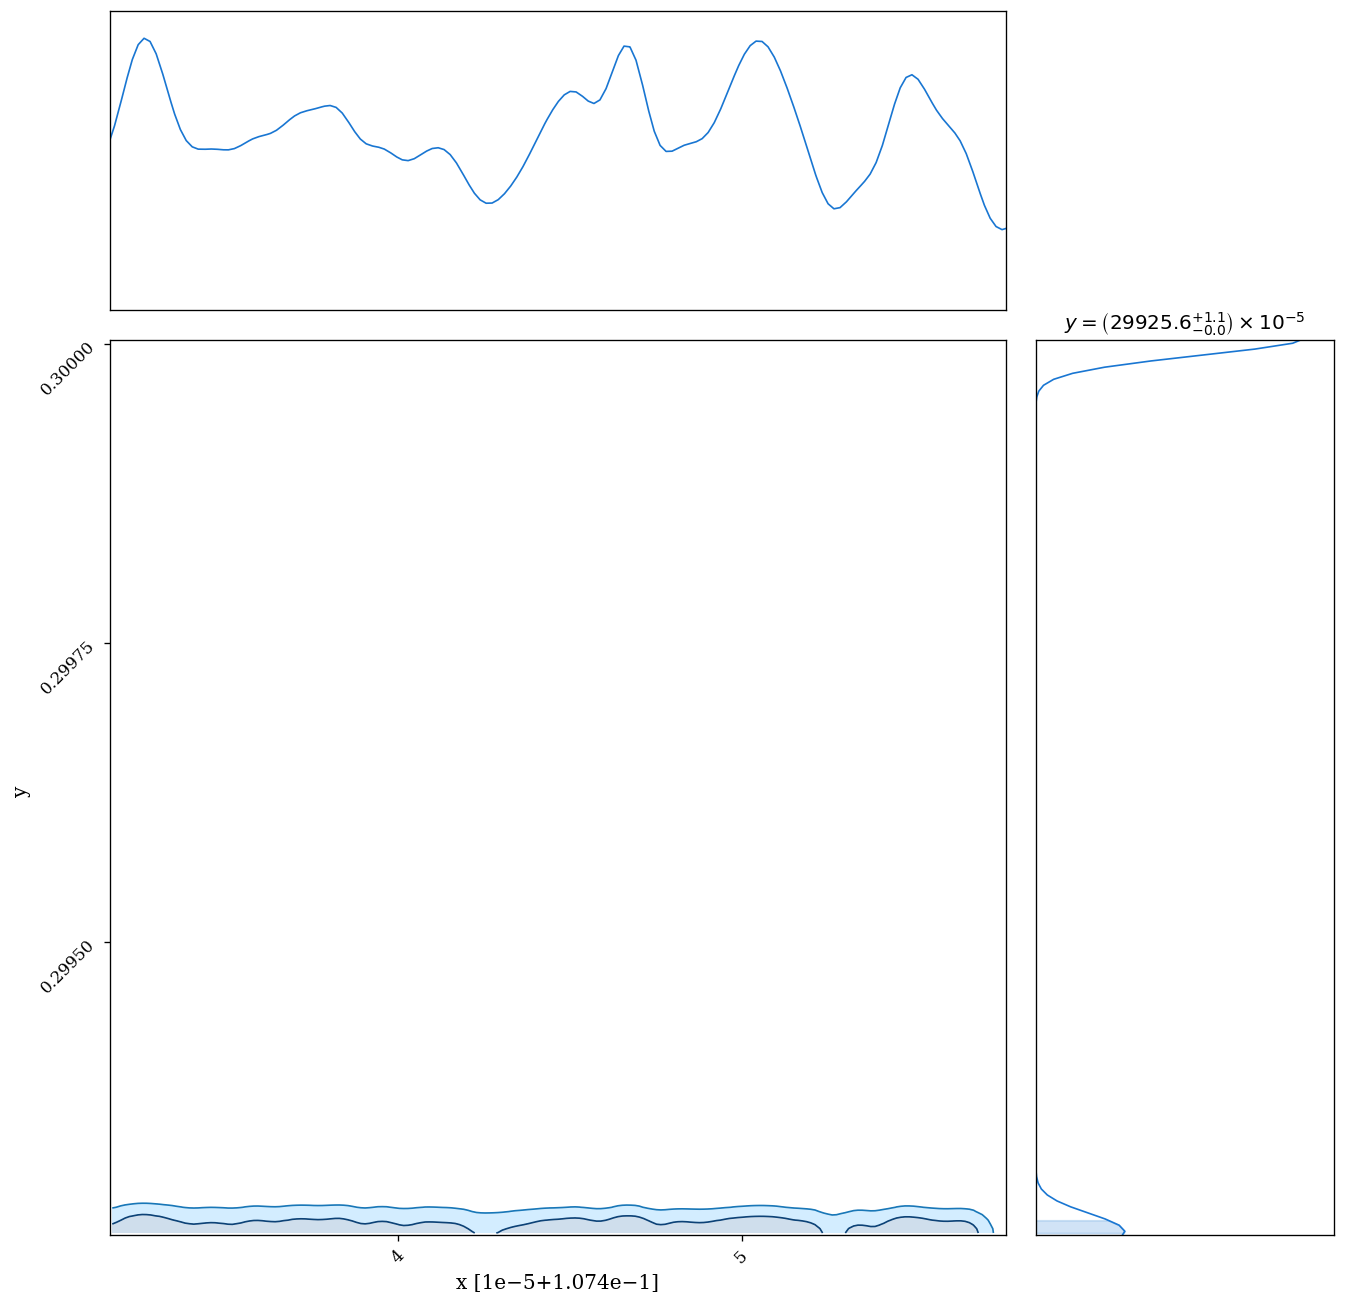

In [349]:
import chainconsumer as cc

chain = cc.ChainConsumer()
chain.add_chain(values_out)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = chain.plotter.plot()
fig.set_size_inches((12,12));

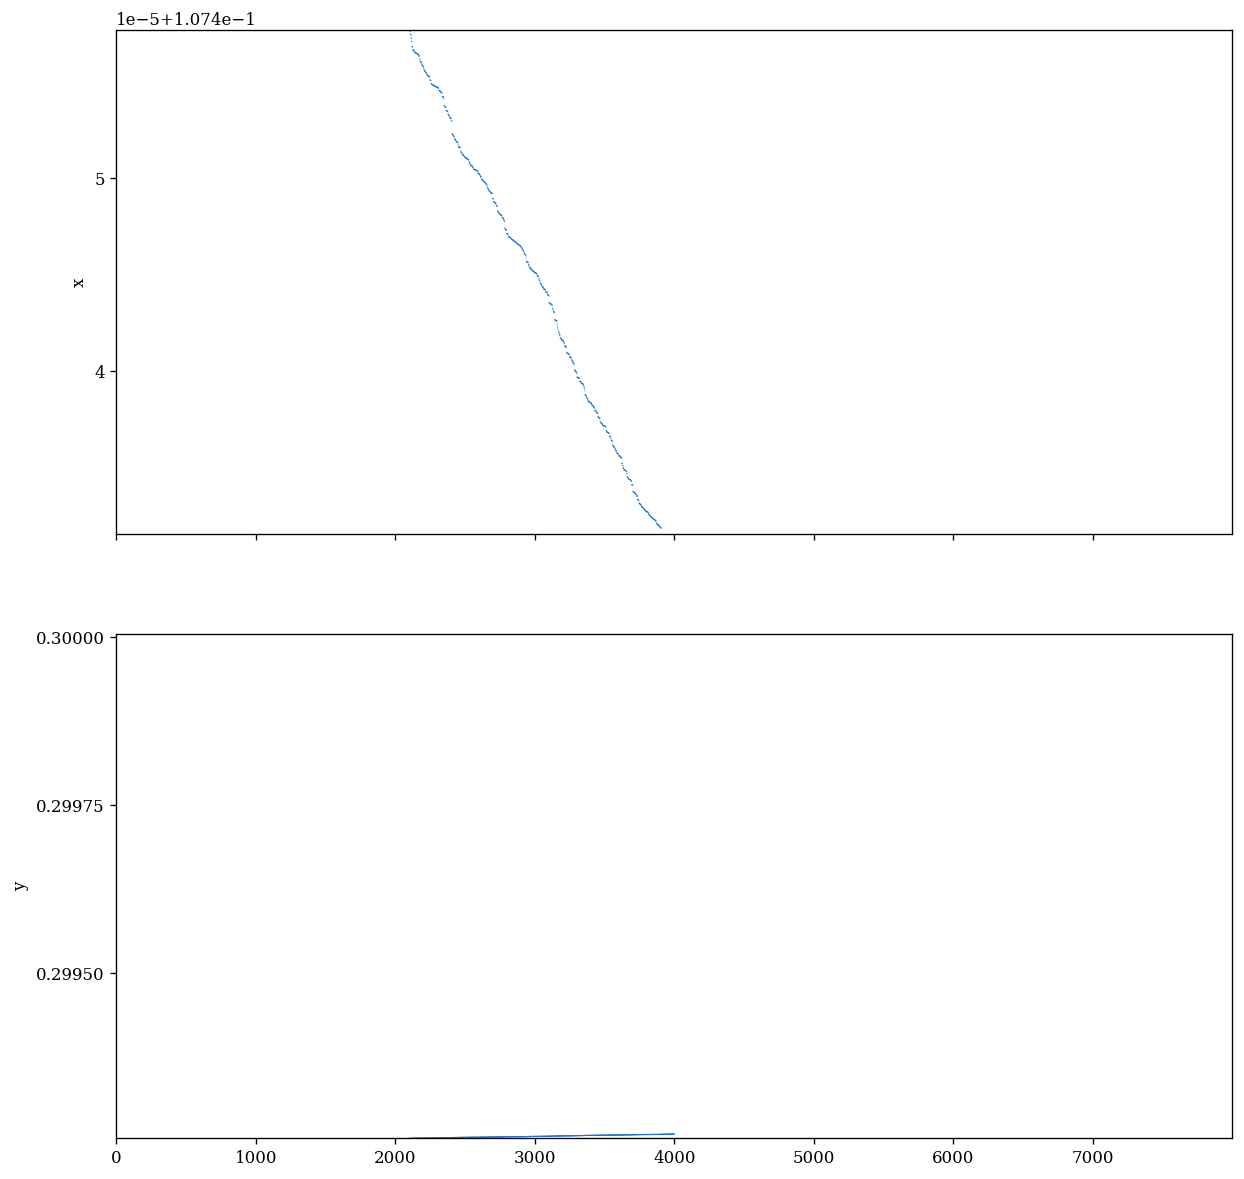

In [350]:
fig = chain.plotter.plot_walks()
fig.set_size_inches((12,12));

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>],
       [<Axes: title={'center': 'y'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

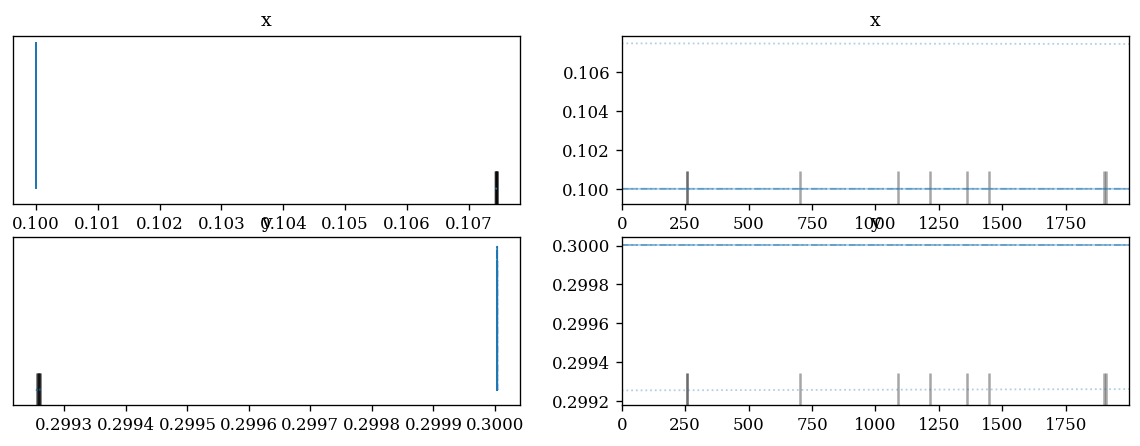

In [351]:

import arviz as az
az.plot_trace(az.from_numpyro(sampler))